<a href="https://colab.research.google.com/github/wayoo2019/Summer-Projects/blob/master/IEEE_2_RFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. RFE Feature Slection
*   LGBM Feature Selection
*   XGB Feature Selection

reference: https://www.kaggle.com/nroman/recursive-feature-elimination

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing

In [ ]:
%%time
train = pd.read_parquet("drive/My Drive/ieee-fraud-detection/train.parquet.gzip")
test = pd.read_parquet("drive/My Drive/ieee-fraud-detection/test.parquet.gzip")

CPU times: user 13.3 s, sys: 4.09 s, total: 17.4 s
Wall time: 13 s


#### 2.1 Remove features which have less information


*   Features with only 1 unique value
*   Features with more than 90% missing values
*   Features with the top value appears more than 90% of the time








In [ ]:
# Features with only 1 unique value
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

# Features with more than 90% missing values
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

# Features with the top value appears more than 90% of the time
big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove("isFraud")

print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))
print(cols_to_drop)


82 features are going to be dropped for being useless
['id_25', 'V24', 'V25', 'V118', 'V116', 'V119', 'V26', 'V137', 'V103', 'V114', 'V135', 'V109', 'V117', 'V27', 'V321', 'V309', 'dist2', 'V284', 'V121', 'V295', 'V297', 'V305', 'V65', 'V111', 'V124', 'V107', 'V67', 'id_22', 'V133', 'V115', 'V14', 'V86', 'id_21', 'id_27', 'id_23', 'V301', 'V101', 'V110', 'V104', 'V296', 'V318', 'V108', 'V89', 'V122', 'V106', 'id_18', 'V320', 'V113', 'V134', 'V55', 'V281', 'V77', 'V98', 'V28', 'id_08', 'id_24', 'V68', 'V286', 'C3', 'V105', 'V136', 'V316', 'V298', 'V66', 'D7', 'V300', 'V23', 'V132', 'V125', 'V88', 'V102', 'V311', 'V123', 'V319', 'V120', 'V290', 'V293', 'V129', 'V112', 'id_07', 'id_26', 'V299']


In [ ]:
# remove columns 
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

#### 2.2 Label Encoding, missing values

In [ ]:
cat_col = train.columns[train.dtypes == "object"].tolist()
print(cat_col)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [ ]:
le = LabelEncoder()
for col in cat_col:
  le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
  train[col] = le.transform(list(train[col].astype(str).values))
  

In [ ]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,NaN,150.0,2,142.0,2,315.0,87.0,19.0,0,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2,1,NaN,NaN,NaN,2,1,48,11,NaN,461,0,1,1,1,1,0,1341
1,2987001,0,86401,29.0,4,2755,404.0,150.0,3,102.0,2,325.0,87.0,NaN,17,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2,1,NaN,NaN,NaN,2,1,48,11,NaN,461,0,1,1,1,1,0,1341
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,3,330.0,87.0,287.0,36,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2,1,NaN,NaN,NaN,2,1,48,11,NaN,461,0,1,1,1,1,0,1341
3,2987003,0,86499,50.0,4,18132,567.0,150.0,3,117.0,3,476.0,87.0,NaN,55,0,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2,1,NaN,NaN,NaN,2,1,48,11,NaN,461,0,1,1,1,1,0,1341
4,2987004,0,86506,50.0,1,4497,514.0,150.0,3,102.0,2,420.0,87.0,NaN,17,0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,2,NaN,-480.0,1,2,166.0,542.0,144.0,1,2,7,162,32.0,268,4,2,0,2,2,2,1566


#### 2.4 RFE feature selection

In [ ]:
X = train.drop(["isFraud"], axis=1)
y = train["isFraud"]

In [ ]:
# RFECV does not support NaNs
X.fillna(-999, inplace=True)

Find the best hyperparameters for lgbm by using bayesian optimization

In [ ]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

In [ ]:
clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)
rfe.fit(X, y)

Fitting estimator with 351 features.
Fitting estimator with 341 features.
Fitting estimator with 331 features.
Fitting estimator with 321 features.
Fitting estimator with 311 features.
Fitting estimator with 301 features.
Fitting estimator with 291 features.
Fitting estimator with 281 features.
Fitting estimator with 271 features.
Fitting estimator with 261 features.
Fitting estimator with 251 features.
Fitting estimator with 241 features.
Fitting estimator with 231 features.
Fitting estimator with 221 features.
Fitting estimator with 211 features.
Fitting estimator with 201 features.
Fitting estimator with 191 features.
Fitting estimator with 181 features.
Fitting estimator with 171 features.
Fitting estimator with 161 features.
Fitting estimator with 151 features.
Fitting estimator with 141 features.
Fitting estimator with 131 features.
Fitting estimator with 121 features.
Fitting estimator with 111 features.
Fitting estimator with 101 features.
Fitting estimator with 91 features.
Fi

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(bagging_fraction=0.4181193142567742,
                               bagging_seed=11, boosting_type='gbdt',
                               class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243,
                               importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1,
                               metric='auc', min_child_samples=20,
                               min_child_we....03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0,
                               n_estimators=100, n_jobs=-1, num_leaves=491,
                               objective='binary', random_state=47,
                               reg_alpha=0.3899927210061127,
                               reg_lambda=0.6485237330340494, silent=True,
                               subsam

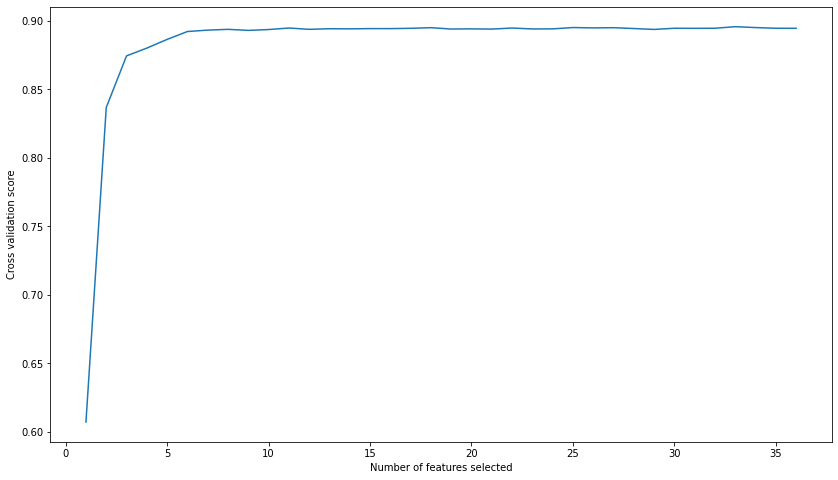

In [ ]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [ ]:
fl = X.columns[rfe.ranking_ == 1].tolist()
print(fl)

['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13', 'V15', 'V16', 'V18', 'V19', 'V20', 'V21', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V139', 'V140', 'V142', 'V143', 'V144', 'V145', 'V146', 'V1

In [ ]:
rfe.grid_scores_

array([0.60726946, 0.83670295, 0.87437818, 0.88006101, 0.88640454,
       0.89214487, 0.89317624, 0.89373871, 0.89297848, 0.89359619,
       0.89470116, 0.89375448, 0.89417606, 0.89411205, 0.89427867,
       0.89427411, 0.89449449, 0.8949534 , 0.89396192, 0.89408605,
       0.89392704, 0.89469669, 0.89402453, 0.89408147, 0.89505155,
       0.89479847, 0.89494307, 0.8943391 , 0.89368272, 0.89453377,
       0.89447409, 0.89455044, 0.89567829, 0.89503128, 0.89454077,
       0.89450327])

In [ ]:
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,

In [ ]:
len(rfe.estimator_.feature_importances_)

321

In [ ]:
rfe_importance= pd.DataFrame()
rfe_importance["Features"] = X.columns[rfe.ranking_ == 1]
rfe_importance["Score"] = rfe.estimator_.feature_importances_
fs_result1.sort_values(by = "Score", ascending=False).head(36)
# rfe_importance.to_csv("rfe_importance.csv")
# !cp rfe_importance.csv "drive/My Drive/ieee-fraud-detection/"

,Features,Score
0,TransactionID,2011
2,TransactionAmt,1899
5,card2,1727
4,card1,1630
26,C13,1602
28,D1,1386
10,addr1,1130
8,card5,1097
29,D2,1042
1,TransactionDT,979


In [ ]:
temp = fs_result1.sort_values(by = "Score", ascending=False).head(36)
rfe_fs = temp["Features"].tolist()
rfe_fs 

['TransactionID',
 'TransactionAmt',
 'card2',
 'card1',
 'C13',
 'D1',
 'addr1',
 'card5',
 'D2',
 'TransactionDT',
 'D15',
 'C1',
 'P_emaildomain',
 'D4',
 'C11',
 'D10',
 'V310',
 'C14',
 'C2',
 'C6',
 'dist1',
 'V313',
 'D8',
 'V307',
 'id_02',
 'V315',
 'R_emaildomain',
 'V130',
 'V127',
 'C9',
 'V317',
 'V312',
 'C12',
 'M4',
 'V308',
 'M5']

In [ ]:
lgb_fs = ['V126', 'V308', 'V131', 'V315', 'C13', 'TransactionID', 'V76', 'C2', 'V317', 'V83', 'C14', 'V127', 'D10', 'V130', 'card1', 'D15', 'V306', 'C11', 'TransactionAmt', 'D1', 'C1', 'V314', 'V307', 'C9', 'C6', 'Hour', 'card5', 'V313', 'addr1', 'V310', 'card2', 'V312', 'C5', 'V320']

In [ ]:
print(set(lgb_fs).intersection(set(rfe_fs))), len(set(lgb_fs).intersection(set(rfe_fs)))

{'C1', 'card1', 'V315', 'D10', 'C6', 'V313', 'V127', 'C13', 'D15', 'C11', 'C14', 'V307', 'V310', 'V130', 'addr1', 'TransactionID', 'TransactionAmt', 'V308', 'C2', 'card2', 'V317', 'D1', 'C9', 'card5', 'V312'}


(None, 25)

In [ ]:
print(set(lgb_fs).difference(set(rfe_fs))), 

{'V314', 'V126', 'V83', 'V320', 'V131', 'V76', 'Hour', 'V306', 'C5'}


(None,)

Because lgb_fs did little FE, the common feature should also 
includes: 'R_emaildomain','TransactionDT', 'V314', the final 30 FE list is:

---


['C1', 'card1', 'V315', 'D10', 'C6', 'V313', 'V127', 'C13', 'D15', 'C11', 'C14', 'V307', 'V310', 'V130', 'addr1', 'TransactionID', 'TransactionAmt', 'V308', 'C2', 'card2', 'V317', 'D1', 'C9', 'card5', 'V312', 'R_emaildomain','TransactionDT', 'V314']